In [104]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import jax.random as jr
import jax.numpy as np

from ssm.ctlds.base import CTLDS

import ssm.ctlds.initial as initial
import ssm.ctlds.dynamics as dynamics
import ssm.ctlds.emissions as emissions

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

from ssm.plots import plot_continuous_dynamics_2d


def plot_emissions(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    # Plot the continuous latent states
    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_timesteps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    for n in range(emissions_dim):
        plt.plot(data[:, n] - lim * n, '-k')
    plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
    plt.xlabel("time")
    plt.xlim(0, num_timesteps)

    plt.title("Sampled Emissions")
    plt.tight_layout()
    

def plot_dynamics(ctlds, states, figsize=(5, 5)):
    fig = plt.figure(figsize=figsize)
    q = plot_continuous_dynamics_2d(drift_matrix=ctlds.drift_matrix, 
                                    drift_bias=ctlds.drift_bias,
                                    mins=states.min(axis=0),
                                    maxs=states.max(axis=0),
                                    color="blue")
    plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
    plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Latent States & Dynamics")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

In [95]:
latent_dim = 2
emission_dim = 3

# Build the components of the CTLDS

# 1) Initial
initial_state_mean = np.zeros(latent_dim)
initial_state_scale_tril = np.eye(latent_dim) * 0.01
myInitial = initial.StandardInitialCondition(initial_state_mean, initial_state_scale_tril)

# 2) Dynamics
drift_matrix = np.array([[-1, -1], 
                         [1, -1]])
diffusion_scale = np.eye(latent_dim) * 0.1
drift_bias = np.zeros((latent_dim,))
myDynamics = dynamics.StationaryDynamics(drift_matrix, drift_bias, diffusion_scale)

# 3) Emissions
rng = jr.PRNGKey(0)
emission_weights = jr.normal(rng, shape=(emission_dim, latent_dim))
emission_bias = np.zeros((emission_dim,))
emission_scale_tril = 0.1**2 * np.eye(emission_dim)

myEmissions = emissions.GaussianEmissions(
    weights=emission_weights,
    bias=emission_bias,
    scale_tril=emission_scale_tril
)

In [96]:
# Construct the CTLDS
ctlds = CTLDS(myInitial, myDynamics, myEmissions)

In [97]:
ctlds

<ssm.lds.CTLDS latent_dim=2 emissions_shape=(3,)>

In [100]:
num_timesteps = 1000

# parameterized by the relative time difference between observations (T-1)
covariates = np.ones((num_timesteps,)) * 0.1

states, data = ctlds.sample(key=jr.PRNGKey(1),
                            covariates=covariates,
                            num_steps=num_timesteps, 
                            num_samples=1)

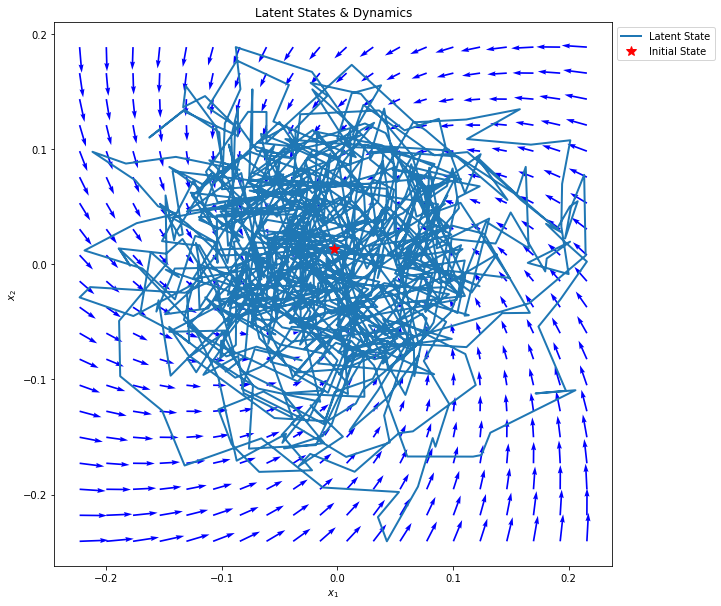

In [101]:
plot_dynamics(ctlds, states, figsize=(10, 10))

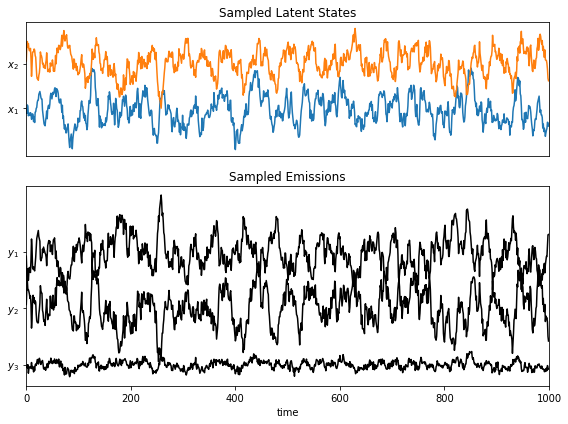

In [102]:
plot_emissions(states, data)